[this demo requires doom installed either from gym-pool or from [ppaquette's repo](https://github.com/ppaquette/gym-doom)]

## Basic Doom demo

* This demo solves DoomBasic env with a simple q-learning with experience replay.

# Experiment setup
* Here we basically just load the game and check that it works

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%env THEANO_FLAGS=device=cuda,floatX=float32

env: THEANO_FLAGS=device=cuda,floatX=float32


In [2]:
import gym
import ppaquette_gym_doom
from gym.wrappers import SkipWrapper
from ppaquette_gym_doom.wrappers.action_space import ToDiscrete
from agentnet.experiments.openai_gym.wrappers import PreprocessImage
GAME_NAME = 'ppaquette/DoomDefendCenter-v0'

make_env = lambda: PreprocessImage(SkipWrapper(4)(ToDiscrete("minimal")(gym.make(GAME_NAME))),
                                   width=80,height=80,grayscale=True)

env = make_env()

Using cuDNN version 5110 on context None
Mapped name None to device cuda: Tesla K80 (0000:00:1E.0)
[2017-06-26 20:57:06,294] Making new env: ppaquette/DoomDefendCenter-v0


In [3]:
#global params.
observation_shape = env.observation_space.shape
n_actions = env.action_space.n
#number of parallel agents and batch sequence length (frames)
N_AGENTS = 1
SEQ_LENGTH = 10

0.0 False


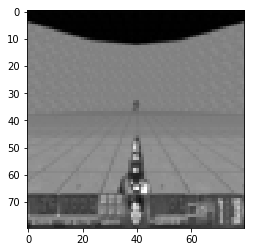

In [4]:
env.reset()
obs,r,done,_=env.step(1)
print(r, done)
plt.imshow(obs[0],cmap='gray',interpolation='none')

# Basic agent setup
Here we define a simple agent that maps game images into Qvalues using simple convolutional neural network.

![scheme](https://s18.postimg.org/gbmsq6gmx/dqn_scheme.png)

In [5]:
#setup and import theano/lasagne. Prefer GPU
%env THEANO_FLAGS=device=cuda,floatX=float32

import theano, lasagne
from lasagne.layers import *

env: THEANO_FLAGS=device=cuda,floatX=float32


In [6]:
#observation
observation_layer = InputLayer((None,)+observation_shape,)

#4-tick window over images
from agentnet.memory import WindowAugmentation, LSTMCell

prev_wnd = InputLayer((None,4)+observation_shape)
new_wnd = WindowAugmentation(observation_layer,prev_wnd)
        
#reshape to (frame, h,w). If you don't use grayscale, 4 should become 12.
wnd_reshape = reshape(new_wnd, (-1,4*observation_shape[0])+observation_shape[1:])


In [7]:
from lasagne.nonlinearities import elu,tanh,softmax
#main neural network body.
#note that we use batch normalization here which speeds up training but may
#get unstable if you use small experience replay buffer
conv0 = Conv2DLayer(wnd_reshape,32,filter_size=(8,8),stride=(4,4),name='conv0')

conv1 = Conv2DLayer(batch_norm(conv0),64,filter_size=(4,4),stride=(2,2),name='conv1')

dense = DenseLayer(batch_norm(conv1),512,name='dense',nonlinearity = lasagne.nonlinearities.tanh)        


In [8]:

#baseline for all qvalues
qvalues_layer = DenseLayer(dense,n_actions,nonlinearity=None,name='qval')
        
#sample actions proportionally to policy_layer
from agentnet.resolver import EpsilonGreedyResolver
action_layer = EpsilonGreedyResolver(qvalues_layer)


In [9]:
from agentnet.target_network import TargetNetwork
targetnet = TargetNetwork(qvalues_layer)
qvalues_old = targetnet.output_layers

##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [10]:
from agentnet.agent import Agent
#all together
agent = Agent(observation_layers=observation_layer,
              policy_estimators=(qvalues_layer,qvalues_old),
              agent_states={new_wnd:prev_wnd},
              action_layers=action_layer)


In [11]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(action_layer,trainable=True)
weights

[conv0.W,
 conv0_bn.beta,
 conv0_bn.gamma,
 conv1.W,
 conv1_bn.beta,
 conv1_bn.gamma,
 dense.W,
 dense.b,
 qval.W,
 qval.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [12]:
from agentnet.experiments.openai_gym.pool import EnvPool

pool = EnvPool(agent,make_env, 
               n_games=N_AGENTS,
               max_size=300) #experience replay pool holding last 1k sessions


[2017-06-26 20:57:07,182] Making new env: ppaquette/DoomDefendCenter-v0


In [13]:
%%time
#interact for 7 ticks
_,action_log,reward_log,_,_,_  = pool.interact(7)


print(action_log[:2])
print(reward_log[:2])

[[0 0 3 1 1 1 0]]
[[ 0.  0.  0.  0.  0.  0.  0.]]
CPU times: user 32 ms, sys: 4 ms, total: 36 ms
Wall time: 85.6 ms


In [14]:
#load first sessions (this function calls interact and remembers sessions)
pool.update(SEQ_LENGTH)

# Q-learning
* An agent has a method that produces symbolic environment interaction sessions
* Such sessions are in sequences of observations, agent memory, actions, q-values,etc
  * one has to pre-define maximum session length.

* SessionPool also stores rewards (Q-learning objective)

In [15]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100,replace=True)

_,_,_,_,(qvalues_seq,old_qvalues_seq) = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)



In [16]:
#get reference Qvalues according to Qlearning algorithm
from agentnet.learning import qlearning

#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2
elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                      replay.actions[0],
                                                      replay.rewards,
                                                      replay.is_alive,
                                                      qvalues_target=old_qvalues_seq,
                                                      gamma_or_gammas=0.99)

#compute mean over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [17]:
# Compute weight updates
updates = lasagne.updates.adam(loss,weights)

#compile train function
import theano
train_step = theano.function([],loss,updates=updates)

# Demo run

In [18]:
action_layer.epsilon.set_value(0)
untrained_reward = np.mean(pool.evaluate(save_path="./records",record_video=True,n_games=10))

[2017-06-26 20:57:37,177] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 20:57:37,185] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-06-26 20:57:37,431] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.0.15102.video000000.mp4


Episode finished after 62 timesteps with reward=0.0


[2017-06-26 20:57:38,893] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.0.15102.video000001.mp4


Episode finished after 56 timesteps with reward=0.0
Episode finished after 66 timesteps with reward=0.0
Episode finished after 55 timesteps with reward=0.0
Episode finished after 70 timesteps with reward=1.0
Episode finished after 50 timesteps with reward=0.0
Episode finished after 75 timesteps with reward=1.0


[2017-06-26 20:57:45,369] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.0.15102.video000008.mp4


Episode finished after 66 timesteps with reward=0.0
Episode finished after 46 timesteps with reward=0.0


[2017-06-26 20:57:47,420] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Episode finished after 70 timesteps with reward=0.0


In [19]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./records/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

# Training loop

In [20]:
#starting epoch
epoch_counter = 1

#full game rewards
rewards = {0:[untrained_reward]}


In [32]:
from tqdm import trange
#the loop may take eons to finish.
#consider interrupting early.
for i in trange(2000, 4000):    
    
    
    #train
    pool.update(SEQ_LENGTH,append=True)
    
    loss = train_step()
    
    targetnet.load_weights(0.01)
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    current_epsilon = 0.05 + 0.95*np.exp(-epoch_counter/200.)
    action_layer.epsilon.set_value(np.float32(current_epsilon))
    
    if epoch_counter%10==0:
        #average reward per game tick in current experience replay pool
        pool_mean_reward = pool.experience_replay.rewards.get_value().mean()
        print("iter=%i\tepsilon=%.3f\treward/step=%.5f"%(epoch_counter,
                                                         current_epsilon,
                                                         pool_mean_reward))
        
    ##record current learning progress and show learning curves
    if epoch_counter%50 ==0:
        rewards[epoch_counter] = pool.evaluate(5, record_video=False)
    
    epoch_counter  +=1

    
# Time to drink some coffee!

  0%|          | 10/2000 [00:03<12:16,  2.70it/s]

iter=2010	epsilon=0.050	reward/step=0.04400


  1%|          | 20/2000 [00:07<11:47,  2.80it/s]

iter=2020	epsilon=0.050	reward/step=0.04367


  2%|▏         | 30/2000 [00:10<11:42,  2.80it/s]

iter=2030	epsilon=0.050	reward/step=0.04400


  2%|▏         | 40/2000 [00:14<11:35,  2.82it/s]

iter=2040	epsilon=0.050	reward/step=0.04300


  2%|▏         | 49/2000 [00:17<11:13,  2.90it/s][2017-06-26 21:37:06,141] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 21:37:06,146] Clearing 12 monitor files from previous run (because force=True was provided)


iter=2050	epsilon=0.050	reward/step=0.04433
Episode finished after 112 timesteps with reward=6.0
Episode finished after 163 timesteps with reward=10.0
Episode finished after 95 timesteps with reward=6.0
Episode finished after 94 timesteps with reward=3.0


[2017-06-26 21:37:13,914] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
  2%|▎         | 50/2000 [00:25<1:27:27,  2.69s/it]

Episode finished after 104 timesteps with reward=6.0


  3%|▎         | 60/2000 [00:28<13:43,  2.36it/s]  

iter=2060	epsilon=0.050	reward/step=0.04433


  4%|▎         | 70/2000 [00:32<11:33,  2.78it/s]

iter=2070	epsilon=0.050	reward/step=0.04500


  4%|▍         | 80/2000 [00:35<11:18,  2.83it/s]

iter=2080	epsilon=0.050	reward/step=0.04467


  4%|▍         | 90/2000 [00:39<11:18,  2.82it/s]

iter=2090	epsilon=0.050	reward/step=0.04533


  5%|▍         | 99/2000 [00:42<10:52,  2.92it/s][2017-06-26 21:37:31,130] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 21:37:31,135] Clearing 2 monitor files from previous run (because force=True was provided)


iter=2100	epsilon=0.050	reward/step=0.04500
Episode finished after 147 timesteps with reward=9.0
Episode finished after 95 timesteps with reward=4.0
Episode finished after 114 timesteps with reward=9.0
Episode finished after 89 timesteps with reward=3.0


[2017-06-26 21:37:39,837] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
  5%|▌         | 100/2000 [00:51<1:34:08,  2.97s/it]

Episode finished after 195 timesteps with reward=13.0


  6%|▌         | 110/2000 [00:54<13:31,  2.33it/s]  

iter=2110	epsilon=0.050	reward/step=0.04533


  6%|▌         | 120/2000 [00:58<11:10,  2.80it/s]

iter=2120	epsilon=0.050	reward/step=0.04633


  6%|▋         | 130/2000 [01:01<11:06,  2.81it/s]

iter=2130	epsilon=0.050	reward/step=0.04700


  7%|▋         | 140/2000 [01:04<10:58,  2.83it/s]

iter=2140	epsilon=0.050	reward/step=0.04833


  7%|▋         | 149/2000 [01:07<10:33,  2.92it/s][2017-06-26 21:37:57,019] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 21:37:57,023] Clearing 2 monitor files from previous run (because force=True was provided)


iter=2150	epsilon=0.050	reward/step=0.04700
Episode finished after 95 timesteps with reward=4.0
Episode finished after 103 timesteps with reward=7.0
Episode finished after 175 timesteps with reward=12.0
Episode finished after 99 timesteps with reward=4.0


[2017-06-26 21:38:04,688] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
  8%|▊         | 150/2000 [01:16<1:22:03,  2.66s/it]

Episode finished after 90 timesteps with reward=4.0


  8%|▊         | 160/2000 [01:19<12:53,  2.38it/s]  

iter=2160	epsilon=0.050	reward/step=0.04833


  8%|▊         | 170/2000 [01:22<10:57,  2.78it/s]

iter=2170	epsilon=0.050	reward/step=0.04833


  9%|▉         | 180/2000 [01:26<10:40,  2.84it/s]

iter=2180	epsilon=0.050	reward/step=0.04900


 10%|▉         | 190/2000 [01:29<10:42,  2.82it/s]

iter=2190	epsilon=0.050	reward/step=0.04900


 10%|▉         | 199/2000 [01:32<10:17,  2.91it/s][2017-06-26 21:38:21,891] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 21:38:21,895] Clearing 2 monitor files from previous run (because force=True was provided)


iter=2200	epsilon=0.050	reward/step=0.05033
Episode finished after 109 timesteps with reward=7.0
Episode finished after 128 timesteps with reward=10.0
Episode finished after 105 timesteps with reward=8.0
Episode finished after 159 timesteps with reward=8.0


[2017-06-26 21:38:30,043] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 10%|█         | 200/2000 [01:41<1:24:15,  2.81s/it]

Episode finished after 98 timesteps with reward=7.0


 10%|█         | 210/2000 [01:44<12:37,  2.36it/s]  

iter=2210	epsilon=0.050	reward/step=0.04933


 11%|█         | 220/2000 [01:48<10:36,  2.80it/s]

iter=2220	epsilon=0.050	reward/step=0.04900


 12%|█▏        | 230/2000 [01:51<10:34,  2.79it/s]

iter=2230	epsilon=0.050	reward/step=0.04900


 12%|█▏        | 240/2000 [01:55<10:29,  2.80it/s]

iter=2240	epsilon=0.050	reward/step=0.05033


 12%|█▏        | 249/2000 [01:58<10:01,  2.91it/s][2017-06-26 21:38:47,337] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 21:38:47,342] Clearing 2 monitor files from previous run (because force=True was provided)


iter=2250	epsilon=0.050	reward/step=0.05100
Episode finished after 99 timesteps with reward=5.0
Episode finished after 159 timesteps with reward=12.0
Episode finished after 98 timesteps with reward=5.0
Episode finished after 129 timesteps with reward=7.0


[2017-06-26 21:38:55,672] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 12%|█▎        | 250/2000 [02:07<1:23:28,  2.86s/it]

Episode finished after 126 timesteps with reward=9.0


 13%|█▎        | 260/2000 [02:10<12:23,  2.34it/s]  

iter=2260	epsilon=0.050	reward/step=0.05067


 14%|█▎        | 270/2000 [02:13<10:24,  2.77it/s]

iter=2270	epsilon=0.050	reward/step=0.05133


 14%|█▍        | 280/2000 [02:17<10:18,  2.78it/s]

iter=2280	epsilon=0.050	reward/step=0.05233


 14%|█▍        | 290/2000 [02:20<10:09,  2.81it/s]

iter=2290	epsilon=0.050	reward/step=0.05233


 15%|█▍        | 299/2000 [02:23<09:45,  2.91it/s][2017-06-26 21:39:13,018] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 21:39:13,023] Clearing 2 monitor files from previous run (because force=True was provided)


iter=2300	epsilon=0.050	reward/step=0.05200
Episode finished after 102 timesteps with reward=6.0
Episode finished after 116 timesteps with reward=7.0
Episode finished after 127 timesteps with reward=10.0
Episode finished after 104 timesteps with reward=6.0


[2017-06-26 21:39:21,579] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 15%|█▌        | 300/2000 [02:32<1:22:56,  2.93s/it]

Episode finished after 177 timesteps with reward=12.0


 16%|█▌        | 310/2000 [02:36<12:07,  2.32it/s]  

iter=2310	epsilon=0.050	reward/step=0.05033


 16%|█▌        | 320/2000 [02:39<10:01,  2.79it/s]

iter=2320	epsilon=0.050	reward/step=0.05067


 16%|█▋        | 330/2000 [02:43<09:51,  2.82it/s]

iter=2330	epsilon=0.050	reward/step=0.04933


 17%|█▋        | 340/2000 [02:46<09:46,  2.83it/s]

iter=2340	epsilon=0.050	reward/step=0.05033


 17%|█▋        | 349/2000 [02:49<09:25,  2.92it/s][2017-06-26 21:39:38,817] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 21:39:38,822] Clearing 2 monitor files from previous run (because force=True was provided)


iter=2350	epsilon=0.050	reward/step=0.04867
Episode finished after 78 timesteps with reward=4.0
Episode finished after 94 timesteps with reward=5.0
Episode finished after 91 timesteps with reward=3.0
Episode finished after 121 timesteps with reward=7.0


[2017-06-26 21:39:45,418] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 18%|█▊        | 350/2000 [02:56<1:04:19,  2.34s/it]

Episode finished after 97 timesteps with reward=5.0


 18%|█▊        | 360/2000 [03:00<11:16,  2.42it/s]  

iter=2360	epsilon=0.050	reward/step=0.04967


 18%|█▊        | 370/2000 [03:03<09:43,  2.80it/s]

iter=2370	epsilon=0.050	reward/step=0.05033


 19%|█▉        | 380/2000 [03:07<09:35,  2.81it/s]

iter=2380	epsilon=0.050	reward/step=0.05100


 20%|█▉        | 390/2000 [03:10<09:28,  2.83it/s]

iter=2390	epsilon=0.050	reward/step=0.05033


 20%|█▉        | 399/2000 [03:13<09:14,  2.89it/s][2017-06-26 21:40:02,671] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 21:40:02,675] Clearing 2 monitor files from previous run (because force=True was provided)


iter=2400	epsilon=0.050	reward/step=0.05133
Episode finished after 102 timesteps with reward=5.0
Episode finished after 165 timesteps with reward=10.0
Episode finished after 99 timesteps with reward=5.0
Episode finished after 123 timesteps with reward=6.0


[2017-06-26 21:40:10,144] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 20%|██        | 400/2000 [03:21<1:09:31,  2.61s/it]

Episode finished after 59 timesteps with reward=1.0


 20%|██        | 410/2000 [03:24<11:06,  2.39it/s]  

iter=2410	epsilon=0.050	reward/step=0.05200


 21%|██        | 420/2000 [03:28<09:29,  2.77it/s]

iter=2420	epsilon=0.050	reward/step=0.05200


 22%|██▏       | 430/2000 [03:31<09:21,  2.79it/s]

iter=2430	epsilon=0.050	reward/step=0.05167


 22%|██▏       | 440/2000 [03:35<09:19,  2.79it/s]

iter=2440	epsilon=0.050	reward/step=0.05133


 22%|██▏       | 449/2000 [03:38<08:56,  2.89it/s][2017-06-26 21:40:27,482] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 21:40:27,487] Clearing 2 monitor files from previous run (because force=True was provided)


iter=2450	epsilon=0.050	reward/step=0.05133
Episode finished after 100 timesteps with reward=4.0
Episode finished after 115 timesteps with reward=7.0
Episode finished after 105 timesteps with reward=5.0
Episode finished after 122 timesteps with reward=6.0


[2017-06-26 21:40:35,369] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 22%|██▎       | 450/2000 [03:46<1:10:34,  2.73s/it]

Episode finished after 135 timesteps with reward=8.0


 23%|██▎       | 460/2000 [03:50<10:47,  2.38it/s]  

iter=2460	epsilon=0.050	reward/step=0.05033


 24%|██▎       | 470/2000 [03:53<09:05,  2.80it/s]

iter=2470	epsilon=0.050	reward/step=0.05033


 24%|██▍       | 480/2000 [03:57<09:00,  2.81it/s]

iter=2480	epsilon=0.050	reward/step=0.05067


 24%|██▍       | 490/2000 [04:00<08:57,  2.81it/s]

iter=2490	epsilon=0.050	reward/step=0.05033


 25%|██▍       | 499/2000 [04:03<08:34,  2.92it/s][2017-06-26 21:40:52,547] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 21:40:52,552] Clearing 2 monitor files from previous run (because force=True was provided)


iter=2500	epsilon=0.050	reward/step=0.04967
Episode finished after 140 timesteps with reward=9.0
Episode finished after 106 timesteps with reward=6.0
Episode finished after 157 timesteps with reward=10.0
Episode finished after 113 timesteps with reward=7.0


[2017-06-26 21:41:01,245] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 25%|██▌       | 500/2000 [04:12<1:14:14,  2.97s/it]

Episode finished after 124 timesteps with reward=6.0


 26%|██▌       | 510/2000 [04:16<10:42,  2.32it/s]  

iter=2510	epsilon=0.050	reward/step=0.05067


 26%|██▌       | 520/2000 [04:19<08:53,  2.78it/s]

iter=2520	epsilon=0.050	reward/step=0.05033


 26%|██▋       | 530/2000 [04:22<08:38,  2.84it/s]

iter=2530	epsilon=0.050	reward/step=0.04933


 27%|██▋       | 540/2000 [04:26<08:36,  2.82it/s]

iter=2540	epsilon=0.050	reward/step=0.04867


 27%|██▋       | 549/2000 [04:29<08:20,  2.90it/s][2017-06-26 21:41:18,473] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 21:41:18,478] Clearing 2 monitor files from previous run (because force=True was provided)


iter=2550	epsilon=0.050	reward/step=0.04933
Episode finished after 116 timesteps with reward=6.0
Episode finished after 105 timesteps with reward=7.0
Episode finished after 136 timesteps with reward=8.0
Episode finished after 103 timesteps with reward=5.0


[2017-06-26 21:41:26,121] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 28%|██▊       | 550/2000 [04:37<1:04:16,  2.66s/it]

Episode finished after 102 timesteps with reward=6.0


 28%|██▊       | 560/2000 [04:40<10:05,  2.38it/s]  

iter=2560	epsilon=0.050	reward/step=0.04900


 28%|██▊       | 570/2000 [04:44<08:33,  2.78it/s]

iter=2570	epsilon=0.050	reward/step=0.04967


 29%|██▉       | 580/2000 [04:47<08:23,  2.82it/s]

iter=2580	epsilon=0.050	reward/step=0.04900


 30%|██▉       | 590/2000 [04:51<08:20,  2.82it/s]

iter=2590	epsilon=0.050	reward/step=0.04967


 30%|██▉       | 599/2000 [04:54<08:02,  2.90it/s][2017-06-26 21:41:43,326] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 21:41:43,331] Clearing 2 monitor files from previous run (because force=True was provided)


iter=2600	epsilon=0.050	reward/step=0.05033
Episode finished after 126 timesteps with reward=9.0
Episode finished after 81 timesteps with reward=4.0
Episode finished after 81 timesteps with reward=4.0
Episode finished after 106 timesteps with reward=6.0


[2017-06-26 21:41:49,880] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 30%|███       | 600/2000 [05:01<54:17,  2.33s/it]

Episode finished after 78 timesteps with reward=5.0


 30%|███       | 610/2000 [05:04<09:30,  2.44it/s]

iter=2610	epsilon=0.050	reward/step=0.05067


 31%|███       | 620/2000 [05:08<08:14,  2.79it/s]

iter=2620	epsilon=0.050	reward/step=0.05133


 32%|███▏      | 630/2000 [05:11<08:11,  2.79it/s]

iter=2630	epsilon=0.050	reward/step=0.05167


 32%|███▏      | 640/2000 [05:15<08:06,  2.79it/s]

iter=2640	epsilon=0.050	reward/step=0.05100


 32%|███▏      | 649/2000 [05:18<07:44,  2.91it/s][2017-06-26 21:42:07,185] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 21:42:07,190] Clearing 2 monitor files from previous run (because force=True was provided)


iter=2650	epsilon=0.050	reward/step=0.05200
Episode finished after 161 timesteps with reward=10.0
Episode finished after 126 timesteps with reward=7.0
Episode finished after 174 timesteps with reward=9.0
Episode finished after 107 timesteps with reward=6.0


[2017-06-26 21:42:15,853] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 32%|███▎      | 650/2000 [05:27<1:06:42,  2.96s/it]

Episode finished after 66 timesteps with reward=2.0


 33%|███▎      | 660/2000 [05:30<09:30,  2.35it/s]  

iter=2660	epsilon=0.050	reward/step=0.05133


 34%|███▎      | 670/2000 [05:34<07:59,  2.78it/s]

iter=2670	epsilon=0.050	reward/step=0.05100


 34%|███▍      | 680/2000 [05:37<07:51,  2.80it/s]

iter=2680	epsilon=0.050	reward/step=0.05133


 34%|███▍      | 690/2000 [05:41<07:49,  2.79it/s]

iter=2690	epsilon=0.050	reward/step=0.05200


 35%|███▍      | 699/2000 [05:44<07:30,  2.89it/s][2017-06-26 21:42:33,201] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 21:42:33,206] Clearing 2 monitor files from previous run (because force=True was provided)


iter=2700	epsilon=0.050	reward/step=0.05167
Episode finished after 126 timesteps with reward=8.0
Episode finished after 82 timesteps with reward=6.0
Episode finished after 213 timesteps with reward=15.0
Episode finished after 115 timesteps with reward=8.0


[2017-06-26 21:42:41,563] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 35%|███▌      | 700/2000 [05:52<1:02:09,  2.87s/it]

Episode finished after 71 timesteps with reward=3.0


 36%|███▌      | 710/2000 [05:56<09:19,  2.30it/s]  

iter=2710	epsilon=0.050	reward/step=0.05200


 36%|███▌      | 720/2000 [05:59<07:36,  2.80it/s]

iter=2720	epsilon=0.050	reward/step=0.05233


 36%|███▋      | 730/2000 [06:03<07:30,  2.82it/s]

iter=2730	epsilon=0.050	reward/step=0.05200


 37%|███▋      | 740/2000 [06:06<07:26,  2.82it/s]

iter=2740	epsilon=0.050	reward/step=0.05200


 37%|███▋      | 749/2000 [06:09<07:09,  2.91it/s][2017-06-26 21:42:58,915] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 21:42:58,920] Clearing 2 monitor files from previous run (because force=True was provided)


iter=2750	epsilon=0.050	reward/step=0.05267
Episode finished after 95 timesteps with reward=5.0
Episode finished after 110 timesteps with reward=6.0
Episode finished after 87 timesteps with reward=6.0
Episode finished after 136 timesteps with reward=9.0


[2017-06-26 21:43:06,705] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 38%|███▊      | 750/2000 [06:18<56:08,  2.70s/it]

Episode finished after 143 timesteps with reward=9.0


 38%|███▊      | 760/2000 [06:21<08:41,  2.38it/s]

iter=2760	epsilon=0.050	reward/step=0.05333


 38%|███▊      | 770/2000 [06:24<07:19,  2.80it/s]

iter=2770	epsilon=0.050	reward/step=0.05233


 39%|███▉      | 780/2000 [06:28<07:15,  2.80it/s]

iter=2780	epsilon=0.050	reward/step=0.05200


 40%|███▉      | 790/2000 [06:31<07:10,  2.81it/s]

iter=2790	epsilon=0.050	reward/step=0.05167


 40%|███▉      | 799/2000 [06:34<06:54,  2.89it/s][2017-06-26 21:43:23,913] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 21:43:23,918] Clearing 2 monitor files from previous run (because force=True was provided)


iter=2800	epsilon=0.050	reward/step=0.05200
Episode finished after 94 timesteps with reward=7.0
Episode finished after 121 timesteps with reward=6.0
Episode finished after 108 timesteps with reward=7.0
Episode finished after 101 timesteps with reward=5.0


[2017-06-26 21:43:31,256] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 40%|████      | 800/2000 [06:42<51:16,  2.56s/it]

Episode finished after 109 timesteps with reward=6.0


 40%|████      | 810/2000 [06:46<08:34,  2.31it/s]

iter=2810	epsilon=0.050	reward/step=0.05133


 41%|████      | 820/2000 [06:49<07:00,  2.80it/s]

iter=2820	epsilon=0.050	reward/step=0.05200


 42%|████▏     | 830/2000 [06:53<06:56,  2.81it/s]

iter=2830	epsilon=0.050	reward/step=0.05300


 42%|████▏     | 840/2000 [06:56<06:50,  2.82it/s]

iter=2840	epsilon=0.050	reward/step=0.05333


 42%|████▏     | 849/2000 [06:59<06:34,  2.91it/s][2017-06-26 21:43:48,636] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 21:43:48,641] Clearing 2 monitor files from previous run (because force=True was provided)


iter=2850	epsilon=0.050	reward/step=0.05367
Episode finished after 142 timesteps with reward=8.0
Episode finished after 161 timesteps with reward=13.0
Episode finished after 131 timesteps with reward=9.0
Episode finished after 151 timesteps with reward=10.0


[2017-06-26 21:43:57,843] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 42%|████▎     | 850/2000 [07:09<59:52,  3.12s/it]

Episode finished after 95 timesteps with reward=4.0


 43%|████▎     | 860/2000 [07:12<08:12,  2.31it/s]

iter=2860	epsilon=0.050	reward/step=0.05400


 44%|████▎     | 870/2000 [07:16<06:44,  2.80it/s]

iter=2870	epsilon=0.050	reward/step=0.05433


 44%|████▍     | 880/2000 [07:19<06:36,  2.82it/s]

iter=2880	epsilon=0.050	reward/step=0.05433


 44%|████▍     | 890/2000 [07:22<06:33,  2.82it/s]

iter=2890	epsilon=0.050	reward/step=0.05433


 45%|████▍     | 899/2000 [07:25<06:17,  2.92it/s][2017-06-26 21:44:15,026] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 21:44:15,031] Clearing 2 monitor files from previous run (because force=True was provided)


iter=2900	epsilon=0.050	reward/step=0.05400
Episode finished after 126 timesteps with reward=7.0
Episode finished after 114 timesteps with reward=7.0
Episode finished after 116 timesteps with reward=7.0
Episode finished after 143 timesteps with reward=9.0


[2017-06-26 21:44:23,648] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 45%|████▌     | 900/2000 [07:34<54:01,  2.95s/it]

Episode finished after 129 timesteps with reward=9.0


 46%|████▌     | 910/2000 [07:38<07:53,  2.30it/s]

iter=2910	epsilon=0.050	reward/step=0.05400


 46%|████▌     | 920/2000 [07:42<06:29,  2.77it/s]

iter=2920	epsilon=0.050	reward/step=0.05333


 46%|████▋     | 930/2000 [07:45<06:22,  2.80it/s]

iter=2930	epsilon=0.050	reward/step=0.05333


 47%|████▋     | 940/2000 [07:49<06:22,  2.77it/s]

iter=2940	epsilon=0.050	reward/step=0.05400


 47%|████▋     | 949/2000 [07:52<06:05,  2.87it/s][2017-06-26 21:44:41,187] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 21:44:41,192] Clearing 2 monitor files from previous run (because force=True was provided)


iter=2950	epsilon=0.050	reward/step=0.05367
Episode finished after 100 timesteps with reward=6.0
Episode finished after 105 timesteps with reward=7.0
Episode finished after 115 timesteps with reward=7.0
Episode finished after 92 timesteps with reward=6.0


[2017-06-26 21:44:48,471] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 48%|████▊     | 950/2000 [07:59<44:37,  2.55s/it]

Episode finished after 120 timesteps with reward=9.0


 48%|████▊     | 960/2000 [08:03<07:15,  2.39it/s]

iter=2960	epsilon=0.050	reward/step=0.05433


 48%|████▊     | 970/2000 [08:06<06:08,  2.80it/s]

iter=2970	epsilon=0.050	reward/step=0.05467


 49%|████▉     | 980/2000 [08:10<06:01,  2.82it/s]

iter=2980	epsilon=0.050	reward/step=0.05433


 50%|████▉     | 990/2000 [08:13<06:04,  2.77it/s]

iter=2990	epsilon=0.050	reward/step=0.05433


 50%|████▉     | 999/2000 [08:16<05:47,  2.88it/s][2017-06-26 21:45:05,761] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 21:45:05,767] Clearing 2 monitor files from previous run (because force=True was provided)


iter=3000	epsilon=0.050	reward/step=0.05400
Episode finished after 118 timesteps with reward=9.0
Episode finished after 120 timesteps with reward=9.0
Episode finished after 85 timesteps with reward=2.0
Episode finished after 112 timesteps with reward=7.0


[2017-06-26 21:45:13,089] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 50%|█████     | 1000/2000 [08:24<42:44,  2.56s/it]

Episode finished after 95 timesteps with reward=5.0


 50%|█████     | 1010/2000 [08:28<07:04,  2.33it/s]

iter=3010	epsilon=0.050	reward/step=0.05467


 51%|█████     | 1020/2000 [08:31<05:51,  2.79it/s]

iter=3020	epsilon=0.050	reward/step=0.05367


 52%|█████▏    | 1030/2000 [08:34<05:47,  2.79it/s]

iter=3030	epsilon=0.050	reward/step=0.05500


 52%|█████▏    | 1040/2000 [08:38<05:41,  2.81it/s]

iter=3040	epsilon=0.050	reward/step=0.05533


 52%|█████▏    | 1049/2000 [08:41<05:26,  2.91it/s][2017-06-26 21:45:30,543] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 21:45:30,548] Clearing 2 monitor files from previous run (because force=True was provided)


iter=3050	epsilon=0.050	reward/step=0.05400
Episode finished after 83 timesteps with reward=5.0
Episode finished after 111 timesteps with reward=8.0
Episode finished after 143 timesteps with reward=9.0
Episode finished after 121 timesteps with reward=9.0


[2017-06-26 21:45:38,423] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 52%|█████▎    | 1050/2000 [08:49<43:08,  2.72s/it]

Episode finished after 120 timesteps with reward=6.0


 53%|█████▎    | 1060/2000 [08:53<06:40,  2.35it/s]

iter=3060	epsilon=0.050	reward/step=0.05500


 54%|█████▎    | 1070/2000 [08:56<05:31,  2.80it/s]

iter=3070	epsilon=0.050	reward/step=0.05500


 54%|█████▍    | 1080/2000 [09:00<05:30,  2.78it/s]

iter=3080	epsilon=0.050	reward/step=0.05533


 55%|█████▍    | 1090/2000 [09:03<05:22,  2.82it/s]

iter=3090	epsilon=0.050	reward/step=0.05600


 55%|█████▍    | 1099/2000 [09:06<05:09,  2.91it/s][2017-06-26 21:45:55,707] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 21:45:55,713] Clearing 2 monitor files from previous run (because force=True was provided)


iter=3100	epsilon=0.050	reward/step=0.05567
Episode finished after 132 timesteps with reward=7.0
Episode finished after 150 timesteps with reward=10.0
Episode finished after 128 timesteps with reward=9.0
Episode finished after 95 timesteps with reward=6.0


[2017-06-26 21:46:03,959] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 55%|█████▌    | 1100/2000 [09:15<42:34,  2.84s/it]

Episode finished after 98 timesteps with reward=8.0


 56%|█████▌    | 1110/2000 [09:18<06:25,  2.31it/s]

iter=3110	epsilon=0.050	reward/step=0.05567


 56%|█████▌    | 1120/2000 [09:22<05:16,  2.78it/s]

iter=3120	epsilon=0.050	reward/step=0.05700


 56%|█████▋    | 1130/2000 [09:25<05:09,  2.81it/s]

iter=3130	epsilon=0.050	reward/step=0.05567


 57%|█████▋    | 1140/2000 [09:29<05:05,  2.82it/s]

iter=3140	epsilon=0.050	reward/step=0.05700


 57%|█████▋    | 1149/2000 [09:32<04:52,  2.91it/s][2017-06-26 21:46:21,409] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 21:46:21,414] Clearing 2 monitor files from previous run (because force=True was provided)


iter=3150	epsilon=0.050	reward/step=0.05533
Episode finished after 143 timesteps with reward=9.0
Episode finished after 152 timesteps with reward=9.0
Episode finished after 136 timesteps with reward=8.0
Episode finished after 104 timesteps with reward=6.0


[2017-06-26 21:46:30,283] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 57%|█████▊    | 1150/2000 [09:41<42:48,  3.02s/it]

Episode finished after 118 timesteps with reward=7.0


 58%|█████▊    | 1160/2000 [09:45<06:00,  2.33it/s]

iter=3160	epsilon=0.050	reward/step=0.05500


 58%|█████▊    | 1170/2000 [09:48<04:53,  2.83it/s]

iter=3170	epsilon=0.050	reward/step=0.05467


 59%|█████▉    | 1180/2000 [09:51<04:48,  2.84it/s]

iter=3180	epsilon=0.050	reward/step=0.05533


 60%|█████▉    | 1190/2000 [09:55<04:48,  2.81it/s]

iter=3190	epsilon=0.050	reward/step=0.05567


 60%|█████▉    | 1199/2000 [09:58<04:35,  2.91it/s][2017-06-26 21:46:47,462] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 21:46:47,467] Clearing 2 monitor files from previous run (because force=True was provided)


iter=3200	epsilon=0.050	reward/step=0.05567
Episode finished after 101 timesteps with reward=6.0
Episode finished after 117 timesteps with reward=8.0
Episode finished after 153 timesteps with reward=11.0
Episode finished after 127 timesteps with reward=7.0


[2017-06-26 21:46:55,754] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 60%|██████    | 1200/2000 [10:07<38:02,  2.85s/it]

Episode finished after 104 timesteps with reward=6.0


 60%|██████    | 1210/2000 [10:10<05:43,  2.30it/s]

iter=3210	epsilon=0.050	reward/step=0.05600


 61%|██████    | 1220/2000 [10:14<04:41,  2.77it/s]

iter=3220	epsilon=0.050	reward/step=0.05633


 62%|██████▏   | 1230/2000 [10:17<04:36,  2.79it/s]

iter=3230	epsilon=0.050	reward/step=0.05733


 62%|██████▏   | 1240/2000 [10:21<04:31,  2.80it/s]

iter=3240	epsilon=0.050	reward/step=0.05633


 62%|██████▏   | 1249/2000 [10:24<04:19,  2.89it/s][2017-06-26 21:47:13,270] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 21:47:13,275] Clearing 2 monitor files from previous run (because force=True was provided)


iter=3250	epsilon=0.050	reward/step=0.05733
Episode finished after 125 timesteps with reward=8.0
Episode finished after 93 timesteps with reward=5.0
Episode finished after 129 timesteps with reward=9.0
Episode finished after 103 timesteps with reward=6.0


[2017-06-26 21:47:20,827] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 62%|██████▎   | 1250/2000 [10:32<32:54,  2.63s/it]

Episode finished after 101 timesteps with reward=7.0


 63%|██████▎   | 1260/2000 [10:35<05:12,  2.37it/s]

iter=3260	epsilon=0.050	reward/step=0.05667


 64%|██████▎   | 1270/2000 [10:39<04:22,  2.78it/s]

iter=3270	epsilon=0.050	reward/step=0.05667


 64%|██████▍   | 1280/2000 [10:42<04:17,  2.80it/s]

iter=3280	epsilon=0.050	reward/step=0.05667


 64%|██████▍   | 1290/2000 [10:46<04:13,  2.80it/s]

iter=3290	epsilon=0.050	reward/step=0.05600


 65%|██████▍   | 1299/2000 [10:49<04:01,  2.90it/s][2017-06-26 21:47:38,152] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 21:47:38,157] Clearing 2 monitor files from previous run (because force=True was provided)


iter=3300	epsilon=0.050	reward/step=0.05633
Episode finished after 179 timesteps with reward=13.0
Episode finished after 86 timesteps with reward=4.0
Episode finished after 124 timesteps with reward=9.0
Episode finished after 180 timesteps with reward=13.0


[2017-06-26 21:47:48,471] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 65%|██████▌   | 1300/2000 [10:59<40:21,  3.46s/it]

Episode finished after 181 timesteps with reward=10.0


 66%|██████▌   | 1310/2000 [11:03<05:12,  2.21it/s]

iter=3310	epsilon=0.050	reward/step=0.05567


 66%|██████▌   | 1320/2000 [11:06<04:02,  2.80it/s]

iter=3320	epsilon=0.050	reward/step=0.05600


 66%|██████▋   | 1330/2000 [11:10<03:57,  2.82it/s]

iter=3330	epsilon=0.050	reward/step=0.05467


 67%|██████▋   | 1340/2000 [11:13<03:53,  2.83it/s]

iter=3340	epsilon=0.050	reward/step=0.05467


 67%|██████▋   | 1349/2000 [11:16<03:44,  2.91it/s][2017-06-26 21:48:05,849] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 21:48:05,854] Clearing 2 monitor files from previous run (because force=True was provided)


iter=3350	epsilon=0.050	reward/step=0.05500
Episode finished after 178 timesteps with reward=12.0
Episode finished after 104 timesteps with reward=5.0
Episode finished after 107 timesteps with reward=8.0
Episode finished after 118 timesteps with reward=6.0


[2017-06-26 21:48:14,377] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 68%|██████▊   | 1350/2000 [11:25<31:36,  2.92s/it]

Episode finished after 121 timesteps with reward=8.0


 68%|██████▊   | 1360/2000 [11:29<04:35,  2.32it/s]

iter=3360	epsilon=0.050	reward/step=0.05433


 68%|██████▊   | 1370/2000 [11:32<03:46,  2.79it/s]

iter=3370	epsilon=0.050	reward/step=0.05500


 69%|██████▉   | 1380/2000 [11:36<03:41,  2.80it/s]

iter=3380	epsilon=0.050	reward/step=0.05500


 70%|██████▉   | 1390/2000 [11:39<03:36,  2.81it/s]

iter=3390	epsilon=0.050	reward/step=0.05467


 70%|██████▉   | 1399/2000 [11:42<03:28,  2.89it/s][2017-06-26 21:48:31,669] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 21:48:31,674] Clearing 2 monitor files from previous run (because force=True was provided)


iter=3400	epsilon=0.050	reward/step=0.05500
Episode finished after 104 timesteps with reward=7.0
Episode finished after 145 timesteps with reward=8.0
Episode finished after 102 timesteps with reward=6.0
Episode finished after 115 timesteps with reward=5.0


[2017-06-26 21:48:39,784] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 70%|███████   | 1400/2000 [11:51<27:59,  2.80s/it]

Episode finished after 129 timesteps with reward=10.0


 70%|███████   | 1410/2000 [11:54<04:10,  2.35it/s]

iter=3410	epsilon=0.050	reward/step=0.05567


 71%|███████   | 1420/2000 [11:57<03:26,  2.80it/s]

iter=3420	epsilon=0.050	reward/step=0.05367


 72%|███████▏  | 1430/2000 [12:01<03:21,  2.83it/s]

iter=3430	epsilon=0.050	reward/step=0.05433


 72%|███████▏  | 1440/2000 [12:04<03:19,  2.81it/s]

iter=3440	epsilon=0.050	reward/step=0.05300


 72%|███████▏  | 1449/2000 [12:07<03:10,  2.90it/s][2017-06-26 21:48:57,008] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 21:48:57,013] Clearing 2 monitor files from previous run (because force=True was provided)


iter=3450	epsilon=0.050	reward/step=0.05467
Episode finished after 166 timesteps with reward=11.0
Episode finished after 105 timesteps with reward=4.0
Episode finished after 134 timesteps with reward=9.0
Episode finished after 114 timesteps with reward=5.0


[2017-06-26 21:49:05,825] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 72%|███████▎  | 1450/2000 [12:17<27:34,  3.01s/it]

Episode finished after 130 timesteps with reward=8.0


 73%|███████▎  | 1460/2000 [12:20<03:51,  2.33it/s]

iter=3460	epsilon=0.050	reward/step=0.05433


 74%|███████▎  | 1470/2000 [12:24<03:08,  2.82it/s]

iter=3470	epsilon=0.050	reward/step=0.05333


 74%|███████▍  | 1480/2000 [12:27<03:08,  2.76it/s]

iter=3480	epsilon=0.050	reward/step=0.05300


 74%|███████▍  | 1490/2000 [12:30<03:02,  2.80it/s]

iter=3490	epsilon=0.050	reward/step=0.05300


 75%|███████▍  | 1499/2000 [12:34<02:51,  2.91it/s][2017-06-26 21:49:23,084] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 21:49:23,088] Clearing 2 monitor files from previous run (because force=True was provided)


iter=3500	epsilon=0.050	reward/step=0.05300
Episode finished after 115 timesteps with reward=6.0
Episode finished after 108 timesteps with reward=7.0
Episode finished after 111 timesteps with reward=8.0
Episode finished after 138 timesteps with reward=8.0


[2017-06-26 21:49:31,450] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 75%|███████▌  | 1500/2000 [12:42<23:54,  2.87s/it]

Episode finished after 143 timesteps with reward=8.0


 76%|███████▌  | 1510/2000 [12:46<03:28,  2.35it/s]

iter=3510	epsilon=0.050	reward/step=0.05300


 76%|███████▌  | 1520/2000 [12:49<02:51,  2.80it/s]

iter=3520	epsilon=0.050	reward/step=0.05300


 76%|███████▋  | 1530/2000 [12:53<02:46,  2.82it/s]

iter=3530	epsilon=0.050	reward/step=0.05267


 77%|███████▋  | 1540/2000 [12:56<02:43,  2.81it/s]

iter=3540	epsilon=0.050	reward/step=0.05367


 77%|███████▋  | 1549/2000 [12:59<02:35,  2.90it/s][2017-06-26 21:49:48,644] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 21:49:48,648] Clearing 2 monitor files from previous run (because force=True was provided)


iter=3550	epsilon=0.050	reward/step=0.05267
Episode finished after 94 timesteps with reward=4.0
Episode finished after 88 timesteps with reward=5.0
Episode finished after 124 timesteps with reward=6.0
Episode finished after 88 timesteps with reward=6.0


[2017-06-26 21:49:55,623] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 78%|███████▊  | 1550/2000 [13:06<18:24,  2.46s/it]

Episode finished after 117 timesteps with reward=9.0


 78%|███████▊  | 1560/2000 [13:10<03:01,  2.42it/s]

iter=3560	epsilon=0.050	reward/step=0.05367


 78%|███████▊  | 1570/2000 [13:13<02:33,  2.80it/s]

iter=3570	epsilon=0.050	reward/step=0.05233


 79%|███████▉  | 1580/2000 [13:17<02:27,  2.84it/s]

iter=3580	epsilon=0.050	reward/step=0.05233


 80%|███████▉  | 1590/2000 [13:20<02:25,  2.82it/s]

iter=3590	epsilon=0.050	reward/step=0.05300


 80%|███████▉  | 1599/2000 [13:23<02:17,  2.92it/s][2017-06-26 21:50:12,818] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 21:50:12,823] Clearing 2 monitor files from previous run (because force=True was provided)


iter=3600	epsilon=0.050	reward/step=0.05333
Episode finished after 140 timesteps with reward=9.0
Episode finished after 73 timesteps with reward=5.0
Episode finished after 134 timesteps with reward=10.0
Episode finished after 114 timesteps with reward=9.0


[2017-06-26 21:50:20,361] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 80%|████████  | 1600/2000 [13:31<17:29,  2.62s/it]

Episode finished after 91 timesteps with reward=6.0


 80%|████████  | 1610/2000 [13:35<02:44,  2.38it/s]

iter=3610	epsilon=0.050	reward/step=0.05333


 81%|████████  | 1620/2000 [13:38<02:16,  2.79it/s]

iter=3620	epsilon=0.050	reward/step=0.05367


 82%|████████▏ | 1630/2000 [13:42<02:11,  2.81it/s]

iter=3630	epsilon=0.050	reward/step=0.05433


 82%|████████▏ | 1640/2000 [13:45<02:08,  2.80it/s]

iter=3640	epsilon=0.050	reward/step=0.05400


 82%|████████▏ | 1649/2000 [13:48<02:00,  2.92it/s][2017-06-26 21:50:37,597] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 21:50:37,602] Clearing 2 monitor files from previous run (because force=True was provided)


iter=3650	epsilon=0.050	reward/step=0.05567
Episode finished after 118 timesteps with reward=10.0
Episode finished after 186 timesteps with reward=12.0
Episode finished after 127 timesteps with reward=7.0
Episode finished after 137 timesteps with reward=9.0


[2017-06-26 21:50:46,928] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 82%|████████▎ | 1650/2000 [13:58<18:25,  3.16s/it]

Episode finished after 121 timesteps with reward=8.0


 83%|████████▎ | 1660/2000 [14:01<02:28,  2.30it/s]

iter=3660	epsilon=0.050	reward/step=0.05600


 84%|████████▎ | 1670/2000 [14:05<01:59,  2.77it/s]

iter=3670	epsilon=0.050	reward/step=0.05567


 84%|████████▍ | 1680/2000 [14:08<01:53,  2.82it/s]

iter=3680	epsilon=0.050	reward/step=0.05600


 84%|████████▍ | 1690/2000 [14:12<01:50,  2.82it/s]

iter=3690	epsilon=0.050	reward/step=0.05633


 85%|████████▍ | 1699/2000 [14:15<01:44,  2.89it/s][2017-06-26 21:51:04,175] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 21:51:04,180] Clearing 2 monitor files from previous run (because force=True was provided)


iter=3700	epsilon=0.050	reward/step=0.05600
Episode finished after 173 timesteps with reward=13.0
Episode finished after 107 timesteps with reward=4.0
Episode finished after 95 timesteps with reward=6.0
Episode finished after 156 timesteps with reward=11.0


[2017-06-26 21:51:12,946] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 85%|████████▌ | 1700/2000 [14:24<14:57,  2.99s/it]

Episode finished after 111 timesteps with reward=6.0


 86%|████████▌ | 1710/2000 [14:27<02:04,  2.33it/s]

iter=3710	epsilon=0.050	reward/step=0.05600


 86%|████████▌ | 1720/2000 [14:31<01:41,  2.76it/s]

iter=3720	epsilon=0.050	reward/step=0.05600


 86%|████████▋ | 1730/2000 [14:34<01:36,  2.80it/s]

iter=3730	epsilon=0.050	reward/step=0.05633


 87%|████████▋ | 1740/2000 [14:38<01:32,  2.80it/s]

iter=3740	epsilon=0.050	reward/step=0.05700


 87%|████████▋ | 1749/2000 [14:41<01:26,  2.90it/s][2017-06-26 21:51:30,214] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 21:51:30,219] Clearing 2 monitor files from previous run (because force=True was provided)


iter=3750	epsilon=0.050	reward/step=0.05700
Episode finished after 166 timesteps with reward=10.0
Episode finished after 101 timesteps with reward=6.0
Episode finished after 132 timesteps with reward=7.0
Episode finished after 218 timesteps with reward=17.0


[2017-06-26 21:51:39,776] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 88%|████████▊ | 1750/2000 [14:51<13:27,  3.23s/it]

Episode finished after 85 timesteps with reward=4.0


 88%|████████▊ | 1760/2000 [14:54<01:47,  2.23it/s]

iter=3760	epsilon=0.050	reward/step=0.05767


 88%|████████▊ | 1770/2000 [14:58<01:22,  2.79it/s]

iter=3770	epsilon=0.050	reward/step=0.05867


 89%|████████▉ | 1780/2000 [15:01<01:17,  2.83it/s]

iter=3780	epsilon=0.050	reward/step=0.05767


 90%|████████▉ | 1790/2000 [15:05<01:15,  2.80it/s]

iter=3790	epsilon=0.050	reward/step=0.05667


 90%|████████▉ | 1799/2000 [15:08<01:08,  2.92it/s][2017-06-26 21:51:57,254] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 21:51:57,259] Clearing 2 monitor files from previous run (because force=True was provided)


iter=3800	epsilon=0.050	reward/step=0.05733
Episode finished after 94 timesteps with reward=9.0
Episode finished after 151 timesteps with reward=10.0
Episode finished after 122 timesteps with reward=8.0
Episode finished after 109 timesteps with reward=8.0


[2017-06-26 21:52:06,326] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 90%|█████████ | 1800/2000 [15:17<10:16,  3.08s/it]

Episode finished after 194 timesteps with reward=15.0


 90%|█████████ | 1810/2000 [15:21<01:22,  2.31it/s]

iter=3810	epsilon=0.050	reward/step=0.05767


 91%|█████████ | 1820/2000 [15:24<01:04,  2.78it/s]

iter=3820	epsilon=0.050	reward/step=0.05800


 92%|█████████▏| 1830/2000 [15:28<01:00,  2.80it/s]

iter=3830	epsilon=0.050	reward/step=0.05733


 92%|█████████▏| 1840/2000 [15:31<00:56,  2.81it/s]

iter=3840	epsilon=0.050	reward/step=0.05800


 92%|█████████▏| 1849/2000 [15:34<00:52,  2.90it/s][2017-06-26 21:52:23,575] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 21:52:23,580] Clearing 2 monitor files from previous run (because force=True was provided)


iter=3850	epsilon=0.050	reward/step=0.05667
Episode finished after 132 timesteps with reward=8.0
Episode finished after 81 timesteps with reward=3.0
Episode finished after 139 timesteps with reward=9.0
Episode finished after 141 timesteps with reward=8.0


[2017-06-26 21:52:31,936] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 92%|█████████▎| 1850/2000 [15:43<07:10,  2.87s/it]

Episode finished after 117 timesteps with reward=6.0


 93%|█████████▎| 1860/2000 [15:46<01:01,  2.29it/s]

iter=3860	epsilon=0.050	reward/step=0.05633


 94%|█████████▎| 1870/2000 [15:50<00:46,  2.79it/s]

iter=3870	epsilon=0.050	reward/step=0.05700


 94%|█████████▍| 1880/2000 [15:53<00:42,  2.80it/s]

iter=3880	epsilon=0.050	reward/step=0.05733


 94%|█████████▍| 1890/2000 [15:57<00:38,  2.82it/s]

iter=3890	epsilon=0.050	reward/step=0.05667


 95%|█████████▍| 1899/2000 [16:00<00:34,  2.91it/s][2017-06-26 21:52:49,381] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 21:52:49,385] Clearing 2 monitor files from previous run (because force=True was provided)


iter=3900	epsilon=0.050	reward/step=0.05633
Episode finished after 97 timesteps with reward=7.0
Episode finished after 168 timesteps with reward=9.0
Episode finished after 113 timesteps with reward=8.0
Episode finished after 128 timesteps with reward=8.0


[2017-06-26 21:52:57,425] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 95%|█████████▌| 1900/2000 [16:08<04:37,  2.77s/it]

Episode finished after 84 timesteps with reward=5.0


 96%|█████████▌| 1910/2000 [16:12<00:38,  2.36it/s]

iter=3910	epsilon=0.050	reward/step=0.05600


 96%|█████████▌| 1920/2000 [16:15<00:28,  2.80it/s]

iter=3920	epsilon=0.050	reward/step=0.05567


 96%|█████████▋| 1930/2000 [16:19<00:24,  2.82it/s]

iter=3930	epsilon=0.050	reward/step=0.05467


 97%|█████████▋| 1940/2000 [16:22<00:21,  2.81it/s]

iter=3940	epsilon=0.050	reward/step=0.05400


 97%|█████████▋| 1949/2000 [16:25<00:17,  2.87it/s][2017-06-26 21:53:14,653] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 21:53:14,658] Clearing 2 monitor files from previous run (because force=True was provided)


iter=3950	epsilon=0.050	reward/step=0.05267
Episode finished after 109 timesteps with reward=7.0
Episode finished after 95 timesteps with reward=5.0
Episode finished after 74 timesteps with reward=4.0
Episode finished after 107 timesteps with reward=4.0


[2017-06-26 21:53:21,548] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 98%|█████████▊| 1950/2000 [16:32<02:01,  2.43s/it]

Episode finished after 111 timesteps with reward=6.0


 98%|█████████▊| 1960/2000 [16:36<00:16,  2.37it/s]

iter=3960	epsilon=0.050	reward/step=0.05300


 98%|█████████▊| 1970/2000 [16:39<00:10,  2.77it/s]

iter=3970	epsilon=0.050	reward/step=0.05367


 99%|█████████▉| 1980/2000 [16:43<00:07,  2.81it/s]

iter=3980	epsilon=0.050	reward/step=0.05233


100%|█████████▉| 1990/2000 [16:46<00:03,  2.84it/s]

iter=3990	epsilon=0.050	reward/step=0.05167


100%|█████████▉| 1999/2000 [16:49<00:00,  2.92it/s][2017-06-26 21:53:38,954] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 21:53:38,959] Clearing 2 monitor files from previous run (because force=True was provided)


iter=4000	epsilon=0.050	reward/step=0.05200
Episode finished after 184 timesteps with reward=12.0
Episode finished after 196 timesteps with reward=14.0
Episode finished after 107 timesteps with reward=5.0
Episode finished after 110 timesteps with reward=6.0


[2017-06-26 21:53:48,944] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
100%|██████████| 2000/2000 [17:00<00:00,  3.36s/it]

Episode finished after 132 timesteps with reward=8.0


# Evaluating results
 * Here we plot learning curves and sample testimonials

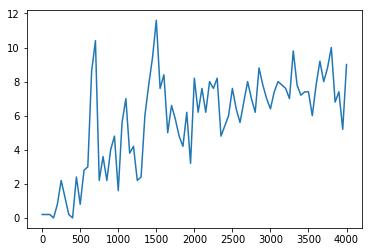

In [33]:
time,rw = zip(*sorted(list(rewards.items()),key=lambda p:p[0]))
plt.plot(time,list(map(np.mean,rw)))
    

In [36]:
import os
tmp = GAME_NAME.split('/')[1]
try:
    os.mkdir(tmp)
except:
    pass
with open('{}/{}'.format(tmp, tmp), 'w') as outp:
    for idx in range(len(time)):
        print(time[idx], rw[idx], file=outp)

In [35]:
action_layer.epsilon.set_value(0.001)
rw = pool.evaluate(n_games=100,save_path="./records",record_video=True)
print("mean session score=%f"%np.mean(rw))

[2017-06-26 21:54:28,985] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 21:54:28,990] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-06-26 21:54:29,229] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.82.15102.video000000.mp4


Episode finished after 90 timesteps with reward=7.0


[2017-06-26 21:54:31,444] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.82.15102.video000001.mp4


Episode finished after 128 timesteps with reward=8.0
Episode finished after 117 timesteps with reward=6.0
Episode finished after 120 timesteps with reward=8.0
Episode finished after 111 timesteps with reward=7.0
Episode finished after 135 timesteps with reward=7.0
Episode finished after 97 timesteps with reward=5.0


[2017-06-26 21:54:43,315] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.82.15102.video000008.mp4


Episode finished after 97 timesteps with reward=7.0
Episode finished after 103 timesteps with reward=7.0
Episode finished after 158 timesteps with reward=11.0
Episode finished after 119 timesteps with reward=8.0
Episode finished after 191 timesteps with reward=14.0
Episode finished after 124 timesteps with reward=7.0
Episode finished after 104 timesteps with reward=5.0
Episode finished after 146 timesteps with reward=11.0
Episode finished after 107 timesteps with reward=6.0
Episode finished after 165 timesteps with reward=10.0
Episode finished after 185 timesteps with reward=12.0
Episode finished after 143 timesteps with reward=11.0
Episode finished after 88 timesteps with reward=4.0
Episode finished after 152 timesteps with reward=11.0
Episode finished after 142 timesteps with reward=10.0
Episode finished after 86 timesteps with reward=7.0
Episode finished after 141 timesteps with reward=11.0
Episode finished after 83 timesteps with reward=6.0
Episode finished after 101 timesteps with

[2017-06-26 21:55:17,131] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.82.15102.video000027.mp4


Episode finished after 91 timesteps with reward=8.0
Episode finished after 114 timesteps with reward=7.0
Episode finished after 99 timesteps with reward=5.0
Episode finished after 140 timesteps with reward=11.0
Episode finished after 88 timesteps with reward=5.0
Episode finished after 119 timesteps with reward=8.0
Episode finished after 128 timesteps with reward=8.0
Episode finished after 142 timesteps with reward=10.0
Episode finished after 83 timesteps with reward=4.0
Episode finished after 138 timesteps with reward=10.0
Episode finished after 151 timesteps with reward=10.0
Episode finished after 172 timesteps with reward=9.0
Episode finished after 102 timesteps with reward=6.0
Episode finished after 111 timesteps with reward=8.0
Episode finished after 114 timesteps with reward=7.0
Episode finished after 102 timesteps with reward=7.0
Episode finished after 106 timesteps with reward=6.0
Episode finished after 99 timesteps with reward=6.0
Episode finished after 161 timesteps with rewar

[2017-06-26 21:56:19,602] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.82.15102.video000064.mp4


Episode finished after 165 timesteps with reward=12.0
Episode finished after 121 timesteps with reward=7.0
Episode finished after 117 timesteps with reward=7.0
Episode finished after 106 timesteps with reward=7.0
Episode finished after 100 timesteps with reward=6.0
Episode finished after 122 timesteps with reward=9.0
Episode finished after 101 timesteps with reward=6.0
Episode finished after 145 timesteps with reward=8.0
Episode finished after 90 timesteps with reward=6.0
Episode finished after 124 timesteps with reward=9.0
Episode finished after 179 timesteps with reward=12.0
Episode finished after 154 timesteps with reward=11.0
Episode finished after 110 timesteps with reward=6.0
Episode finished after 189 timesteps with reward=16.0
Episode finished after 128 timesteps with reward=7.0
Episode finished after 145 timesteps with reward=10.0
Episode finished after 138 timesteps with reward=10.0
Episode finished after 161 timesteps with reward=10.0
Episode finished after 109 timesteps wit

[2017-06-26 21:57:27,460] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Episode finished after 84 timesteps with reward=5.0
mean session score=8.470000


In [25]:
gym.scoreboard.api_key = 'sk_X6PO6hv9Rq24jaL21xROSA'
#gym.upload('/home/ubuntu/records')

[2017-06-26 21:16:03,199] [ppaquette/DoomDefendCenter-v0] Uploading 100 episodes of training data
[2017-06-26 21:16:03,661] [ppaquette/DoomDefendCenter-v0] Uploading videos of 5 training episodes (4494411 bytes)
[2017-06-26 21:16:03,876] [ppaquette/DoomDefendCenter-v0] Creating evaluation object from /home/ubuntu/records with learning curve and training video


InvalidRequestError: Request req_DaYTqOurTy6YQbdJlX8dMQ: This version of the environment is not registered on the server, but other versions exist. You may need to upgrade your version of gym. Env ppaquette/DoomDefendCenter-v0 not found (valid versions include ['DoomDefendCenter-v0'])

In [37]:
from agentnet.utils.persistence import save,load
#save for display
save(action_layer,"{}/{}.pcl".format(tmp, tmp))

In [27]:
from IPython.display import HTML
import os
from random import choice
#select the one you want
videos = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))
video_path="./records/"+choice(videos)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_path))


## Get serious

* Switch to DoomDefendCenter, DoomHealthGathering, DoomDeathmatch or similar
* Deploy a better RL algorithm
* Deploy a better network. Doom will likely need some recurrent nets